In [137]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import csv

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/better-ckpt/lstm_v11_to1203.ckpt
/kaggle/input/simple-ckpt/lstm_v10_to1203.ckpt
/kaggle/input/simple-ckpt/lstm_v10_to1203 (3).ckpt
/kaggle/input/allstops-inf-1211-1217/allstops_inf_1211_to_1217.csv
/kaggle/input/allstops-inf-1204-1210/allstops_inf_1204_to_1210.csv
/kaggle/input/allstops-inf-1021-1024/allstops_inf_1021_to_1024.csv
/kaggle/input/filled-csv-to1203/filled_csv_to1203.csv


## Import Libraries

In [138]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

## Define all paths

In [139]:
data_path_to1203 = "/kaggle/input/filled-csv-to1203/filled_csv_to1203.csv"
inference_path_1021_1024 = "/kaggle/input/allstops-inf-1021-1024/allstops_inf_1021_to_1024.csv"
inference_path_1204_1210 = "/kaggle/input/allstops-inf-1204-1210/allstops_inf_1204_to_1210.csv"
inference_path_1211_1217 = "/kaggle/input/allstops-inf-1211-1217/allstops_inf_1211_to_1217.csv"
output_path_to1203 = "predictions_lstm_full.csv"
ckpt_path = "/kaggle/working/lstm_v10_to1203.ckpt"

## Data preprocessing
### - configurations

In [140]:
total_stops = 112
total_days = 55    # 10/2 ~ 12/3
valid_days = 14    # 11/20 ~ 12/3
day_period = 72
stop_period = total_days * day_period
lookback = 2 * day_period  # 2 days
lookforward = 1 # 1 time
idx = {'10/11_23:40': 719,'10/16_00:00': 720,'10/19_00:00': 936,'10/20_23:40': 1079,'10/25_00:00': 1080,'11/18_23:40': 2879,'12/02_00:00': 3816,'12/03_23:40': 3959,'12/07_00:00': 4176}
# print(idx['10/11_23:40'])
# datafile = pd.read_csv(data_path_to1203)
# features_timeseries = datafile[[c for c in datafile.columns if c in ['weekday','hr','min','lat','lng','act','ratio']]].values.astype('float32')
# print(features_timeseries[idx['11/18_23:40']])

### - define functions

In [141]:
def create_dataset(training_data):
    """Transform a time series into a prediction dataset, from lookback predict lookforward
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, Y = [], []

    for stop in range(total_stops):
        for i in range(len(training_data[stop]) - (lookback + lookforward)):
            if i + lookback + lookforward > (stop+1)*idx['10/11_23:40'] and i < (stop+1)*idx['10/16_00:00']:
                continue
            if i + lookback + lookforward > (stop+1)*idx['10/20_23:40'] and i < (stop+1)*idx['10/25_00:00']:
                continue
            x = training_data[stop][i:i + lookback]
            y = training_data[stop][i + lookback:i + lookback + lookforward][:,-1] # ratio at [:,-1]
            X.append(x)
            Y.append(y)
        
    return torch.tensor(np.array(X)), torch.tensor(np.array(Y))

In [142]:
def train_valid_split(timeseries):
    # train-valid split with 10/2~11/19, 11/20~12/03 (2 weeks)
    train_size = (total_days - valid_days) * day_period # 2952
    valid_size = valid_days * day_period
    train = []
    valid = []
    for stop in range(total_stops):
        train.append(timeseries[stop * stop_period : stop * stop_period + train_size])
        valid.append(timeseries[stop * stop_period + train_size : stop * (stop_period) + stop_period])
    print(f"train.shape = {np.array(train).shape}, valid.shape = {np.array(valid).shape}")

    X_train, Y_train = create_dataset(train)
    X_valid, Y_valid = create_dataset(valid)

    print("X.shape = [batch, seq, features], Y.shape = [batch, seq]")
#     print(Y_train[0])
    print(f"X_train.shape = {X_train.shape}, Y_train.shape = {Y_train.shape}")
    print(f"X_valid.shape = {X_valid.shape}, Y_valid.shape = {Y_valid.shape}")
    return X_train, Y_train, X_valid, Y_valid

In [143]:
# datafile = pd.read_csv(data_path_to1203)
# features_timeseries = datafile[[c for c in datafile.columns if c in ['weekday','hr','min','lat','lng','act','ratio']]].values.astype('float32')
# print(f"origin_data.shape = {features_timeseries.shape}")
# X_train, y_train, X_valid, y_valid = train_valid_split(features_timeseries)

In [144]:
def read_full_dataset(data_path, batch_size):
    datafile = pd.read_csv(data_path)
    features_timeseries = datafile[[c for c in datafile.columns if c in ['weekday','hr','min','lat','lng','act','ratio']]].values.astype('float32')
    print(f"origin_data.shape = {features_timeseries.shape}")
    X_train, Y_train, X_valid, Y_valid = train_valid_split(features_timeseries)
    train_loader = DataLoader(TensorDataset(X_train, Y_train), shuffle=False, batch_size=batch_size)
    valid_loader = DataLoader(TensorDataset(X_valid, Y_valid), shuffle=False, batch_size=batch_size)
    return train_loader, valid_loader

In [145]:
def read_inf_dataset(inf_path, batch_size):
    df_inf = pd.read_csv(inf_path)
    inf_timeseries = df_inf[[c for c in df_inf.columns if c in ['month','day','weekday','hr','min','lat','lng','act','tot','title']]].values.tolist()
    print(f"inf_timeseries.shape = {len(inf_timeseries)}")
    test_loader = DataLoader(inf_timeseries, shuffle=False, batch_size=batch_size)
    return test_loader

In [146]:
def get_test_dataset(period):
    test = []
    datafile = pd.read_csv(data_path_to1203)
    features_timeseries = datafile[[c for c in datafile.columns if c in ['weekday','hr','min','lat','lng','act','ratio']]].values.astype('float32')
    
    if period == '1021-1024':
        # fetch data from 1019 to 1020
        for stop in range(total_stops):
            test.append(features_timeseries[stop * stop_period + idx['10/19_00:00']: stop * stop_period + idx['10/20_23:40'] + 1])
    elif period == '1204-1210':
        # fetch data from 1202 to 1203
        for stop in range(total_stops):
            test.append(features_timeseries[stop * stop_period + idx['12/02_00:00']: stop * stop_period + idx['12/03_23:40'] + 1])
    print(f"test_dataset.shape = {np.array(test).shape}")
    return np.array(test)

In [147]:
def shift_test_dataset(test_dataset, new_data):
    """Shift the data to the next time
    
    Args:
        dataset: A numpy array of time series, size = 2 days
        new data: New prediction append to dataset to shift window
    """
    X = test_dataset
    if new_data != None:
        X = np.concatenate((test_dataset, np.array(new_data)), axis=1)
        X = X[:,1:,:]
    return torch.tensor(np.array(X))

## Build a basic LSTM model

In [148]:
class UBikeLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, drop_prob, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = layer_dim
        self.output_size = output_dim
        
        # initialize LSTM   
        self.block = nn.Sequential(
            nn.LSTM(input_dim, hidden_dim, layer_dim, dropout=drop_prob, batch_first=True, bidirectional=False),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout=drop_prob, batch_first=True, bidirectional=False)
        # the output of LSTM is classified by linear and sigmoid functions
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device) # hidden state
        c_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device) # internal state
        lstm_out, (hn, cn)  = self.lstm(x)
#         print(f"lstm_out.shape = {lstm_out.shape}") # [28, 144, 128] (N=batch size,L=seq,H=hidden) 
        lstm_out = lstm_out[:,-1,:]
        out = self.linear(lstm_out) # [32,hidden=128] to [32,output=72]
        out = self.sigmoid(out)
        
        return out

## Loss function

In [149]:
def getLoss(pred, label):
#     loss = torch.mean(3 * torch.abs(pred-label) * (torch.abs(pred-1/3) + torch.abs(pred-2/3)))
    loss = torch.mean(torch.square(pred-label))
#     print(f"loss = {loss}")
    return loss

## Configurations

In [150]:
config = {
    "batch_size": 28,
    "epochs": 100,
    "learning_rate": 1e-4,
    "weight_decay": 5e-3,
    "save_dir": "/kaggle/working/",
    "model_name": "lstm_v11_to1203_100.ckpt",
    "early_stop": 30,
}

# model parameters
window_size = lookback
input_dim =  7 # number of features !!!
hidden_dim = 128   # the hidden dim
layer_dim = 3   # the number of hidden layers
output_dim = lookforward
drop_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Training Part

In [151]:
def train(model, config, train_loader, valid_loader, device):
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay']) 
#     optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'], momentum=0.1)
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=1,T_mult=2)

    n_epochs, best_loss, step, early_stop_count = config['epochs'], 10000, 0, 0
    actual_ratio = [[] for i in range(total_stops*2)]
    pred_ratio = [[] for i in range(total_stops*2)]
    mse_loss_train = []
    mse_loss_val = []
    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x) 
#             print(f"pred.shape = {pred.shape}, y.shape = {y.shape}") # [32,72]
#             print(f"pred = {pred.detach().cpu()[0][0]}, y = {y[0][0]}")
            loss = getLoss(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
        
        scheduler.step()
        mean_train_loss = sum(loss_record)/len(loss_record)
        mse_loss_train.append(mean_train_loss)
        print(len(mse_loss_train))
        
        model.eval() # Set your model to evaluation mode.
        loss_record = []
        count = 0
        stop = 0
        temp = []
        for i, (x, y) in enumerate(valid_loader):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                if i == 0:
                    print(f"pred = {pred}, y = {y}")
                loss = getLoss(pred, y)
            
            if epoch == n_epochs - 1:
                temp.append(stop)
#                 print(f"count={count},stop={stop}")
                actual_ratio[stop].append(y[0][0].item())
                pred_ratio[stop].append(pred.detach().cpu()[0][0])
                if (count+1) % (2952 - 145) == 0:
                    stop += 1
                count += 1
                
            loss_record.append(loss.item())

        if epoch == n_epochs - 1:
#             print(f"actual_ratio[0] = {actual_ratio[0]}")
#             print(f"pred_ratio[0] = {pred_ratio[0]}")
            plt.plot(actual_ratio[0])
            plt.plot(pred_ratio[0])
            plt.legend(['actual', 'predict'])
            plt.title("Train / Valid")
#             plt.savefig("Train/Valid.png")
            plt.show()
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        mse_loss_val.append(mean_valid_loss)
        
        # Note that step should be called after validate() when applying ReduceLROnPlateau sheduler
#         scheduler.step(mean_valid_loss)
        
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_dir'] + config['model_name']) # Save your best model
            if(epoch % 10 == 0):
                print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1
            
        if(epoch % 10 == 0):
            print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        # writer.add_scalar('Loss/valid', mean_valid_loss, step)

            if early_stop_count >= config['early_stop']:
                print('\nModel is not improving, so we halt the training session.')
                print('best loss {:.3f}...'.format(best_loss))
                return
            
    plt.plot(mse_loss_train)
    plt.plot(mse_loss_val)
    plt.title("MSE loss = {:.3f}".format(best_loss))
    plt.legend(['train', 'valid'])
    plt.savefig('mse_loss.png')
#     plt.show()
            

## Inference part

In [152]:
def predict(test_dataset, test_loader, model, device, output_path):
    model.eval() # Set your model to evaluation mode.
    preds = []
    tots = []
    titles = []
    ratio = test_dataset[:,:,-1]
    ratio_list = test_dataset[0,:,-1]
    pred_112_504 = []
    batch_size = config['batch_size']
    month = 12
    for i, (month,day,weekday,hr,min,lat,lng,act,tot,title) in enumerate(test_loader):
        ratio_b = ratio[(i%4)*batch_size:((i%4)+1)*batch_size,:] # [28,144,1]
        # new_data.shape = [112,1,1]
        stack = torch.hstack((weekday.unsqueeze(1),hr.unsqueeze(1),min.unsqueeze(1),lat.unsqueeze(1),lng.unsqueeze(1),act.unsqueeze(1)))
#         print(torch.FloatTensor(test_dataset[(i%4)*batch_size:((i%4)+1)*batch_size,-1,-1]).shape)
        
        test_dataset_b = torch.FloatTensor((test_dataset[(i%4)*batch_size:((i%4)+1)*batch_size,:,:]))
#         print(f"test_dataset_b.shape = {test_dataset_b.shape}")
        
        month = month[0].item()
        tot = tot.tolist()
        title = list(title)
        
        if i == 0:
            x = test_dataset_b
        
#         print(f"x.shape={x.shape}") # [112, 144, 7]
        x = x.to(torch.float32)
        x = x.to(device)      
        tots = tots + tot
        titles = titles + title
        
        with torch.no_grad():  
            pred = model(x)   # tensor
#             print(len(pred.tolist())) # (28,1)
            
            if i % 4 != 0:
                pred_112_1 = torch.vstack((pred_112_1, pred))
                if i == 503:
                    pred_112_504.append(pred_112_1.tolist())
            else:
                if i != 0:
                    pred_112_504.append(pred_112_1.tolist())
                pred_112_1 = pred

            new_data = torch.hstack((stack,torch.FloatTensor(pred.detach().cpu())))
#             print(f"new_data.shape = {np.array(new_data).shape}") # (28,7)
            
            x = shift_test_dataset(x.cpu(), new_data.reshape(batch_size,1,input_dim))
        
    print(f'pred_112_504 shape: {np.array(pred_112_504).shape}') # [504,112,1]
    preds = torch.Tensor(pred_112_504).permute(1,0,2).squeeze(2) # (112,504)
    print(len(preds), len(tots), len(titles))
    print(f"preds shape = {np.array(preds).shape}")
#     print(f"preds[20] = {preds[20]}")
    
#     ratio_list.append(preds[0].tolist())
    ratio_list = np.concatenate((ratio_list,np.array(preds[0])))
    print(np.array(ratio_list).shape)
    plt.plot(ratio_list) # 144 + 504 = 648
    plt.title("Predictions")
    plt.show()
    plt.close()
    
    plt.plot(np.array(preds[0]))
    plt.title("pred_stop_001_1204_1210" +".png")
    plt.savefig("pred_stop_001_" + str(month) +".png")
#     plt.show()
    plt.close()
    
    preds_56448_1 = []
    for i in range(len(preds[0])):
        for j in range(len(preds)):
            preds_56448_1.append(preds[j][i].item())
            
#     print(preds_56448_1)
    
    print(f"len(preds_56448_1) = {len(preds_56448_1)}, len(tots) = {len(tots)}")
    assert len(preds_56448_1) == len(tots)
    assert len(tots) == len(titles)
    prediction = []
    
    if month == 12:
        prediction = [['id','sbi']]
    for (pred, tot, title) in zip(preds_56448_1, tots, titles):
#         title = title.split('_')
#         real_title = title[0] + '_' + stop + '_' + title[2]
        prediction.append([title, pred*tot])
    
    with open(output_path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(prediction) # Use writerows for nested list
        
    return

## Start training and predicting !!!

origin_data.shape = (443520, 7)
train.shape = (112, 2952, 7), valid.shape = (112, 1008, 7)
X.shape = [batch, seq, features], Y.shape = [batch, seq]
X_train.shape = torch.Size([313580, 144, 7]), Y_train.shape = torch.Size([313580, 1])
X_valid.shape = torch.Size([96511, 144, 7]), Y_valid.shape = torch.Size([96511, 1])


Epoch [1/1]: 100%|██████████| 11200/11200 [01:46<00:00, 105.32it/s, loss=0.0116]  


1
pred = tensor([[0.0682],
        [0.1516],
        [0.1690],
        [0.1965],
        [0.1687],
        [0.1527],
        [0.1661],
        [0.1625],
        [0.1504],
        [0.1734],
        [0.1792],
        [0.1716],
        [0.3675],
        [0.5790],
        [0.6851],
        [0.7008],
        [0.7272],
        [0.7238],
        [0.6980],
        [0.7651],
        [0.7880],
        [0.7401],
        [0.6786],
        [0.2954],
        [0.2145],
        [0.1412],
        [0.1121],
        [0.0895]], device='cuda:0'), y = tensor([[0.2143],
        [0.1786],
        [0.2143],
        [0.1786],
        [0.2143],
        [0.2143],
        [0.2143],
        [0.2143],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.8214],
        [0.8214],
        [0.8214],
        [0.8214],
        [0.8214],
        [0.7857],
        [0.8214],
        [0.9643],
        [0.8929],
        [0.7857],
        [0.6786],
        [0.1786],
        [0.1429],
        [0.0357],
        [0.107

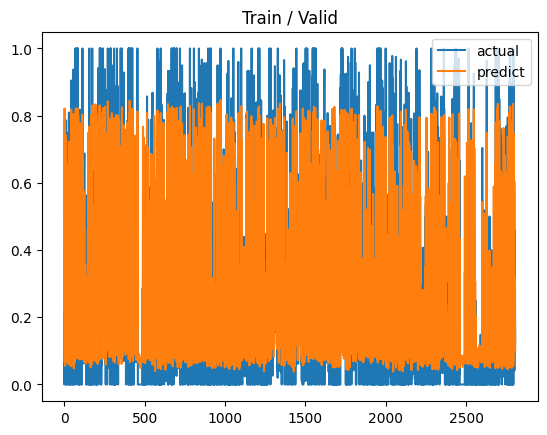

Saving model with loss 0.021...
Epoch [1/1]: Train loss: 0.0823, Valid loss: 0.0211
Start predicting from 1204 to 1210...
inf_timeseries.shape = 56448
test_dataset.shape = (112, 144, 7)
pred_112_504 shape: (504, 112, 1)
112 56448 56448
preds shape = (112, 504)
(648,)


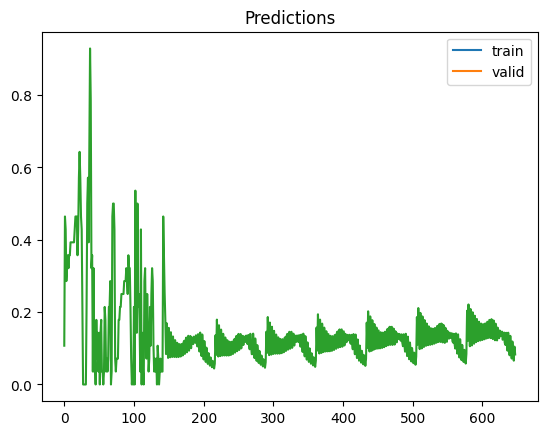

len(preds_56448_1) = 56448, len(tots) = 56448
Start predicting from 1021 to 1024...
inf_timeseries.shape = 32256
test_dataset.shape = (112, 144, 7)
pred_112_504 shape: (288, 112, 1)
112 32256 32256
preds shape = (112, 288)
(432,)


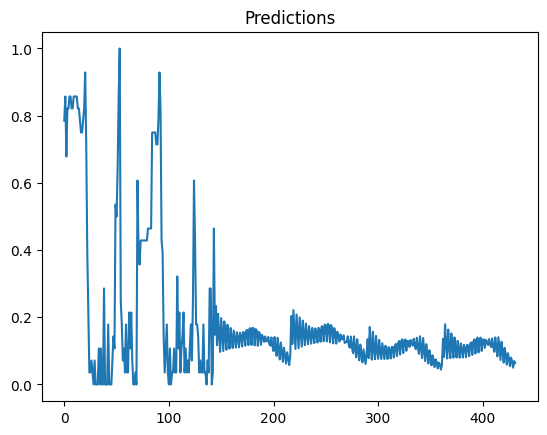

len(preds_56448_1) = 32256, len(tots) = 32256
Finish prediction


In [153]:
# Assign model and start training...
model = UBikeLSTM(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, drop_prob=drop_prob, output_dim=output_dim).to(device)
train_loader, valid_loader = read_full_dataset(data_path_to1203, batch_size=config['batch_size'])
train(model, config, train_loader, valid_loader, device)

# checkpoint = torch.load("/kaggle/input/better-ckpt/lstm_v11_to1203.ckpt")
# model.load_state_dict(checkpoint)

print("Start predicting from 1204 to 1210...")

test_loader = read_inf_dataset(inference_path_1204_1210, batch_size=config['batch_size'])
test_dataset = get_test_dataset(period='1204-1210')
predict(test_dataset, test_loader, model, device, output_path=output_path_to1203)

print("Start predicting from 1021 to 1024...")

test_loader = read_inf_dataset(inference_path_1021_1024, batch_size=config['batch_size'])
test_dataset = get_test_dataset(period='1021-1024')
predict(test_dataset, test_loader, model, device, output_path=output_path_to1203)
        
print("Finish prediction")